In [1]:
from nltk.sentiment.util import *
from nltk.sentiment import SentimentIntensityAnalyzer
import pycountry
from nltk.corpus import words
import pandas as pd
import nltk
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt
from nltk.corpus import opinion_lexicon

%matplotlib inline

# Sentiment analysis on hillary clinton Emails

- For this exercises we will implement a sentiment analysis on hillary emails and grouping them by country

In [2]:
data=pd.read_csv("Emails.csv")
data.fillna(' ',inplace=True)

- we load the data and we clean it to be able to use it for the sentiment analysis.
- We don't lower the text since we think that it could be more significant that hillary uses for instance AM as an alpha_2 code for a country than am or Am that could represent 'I am in ..'
- We remove stop words and non character tokens

In [3]:
raw=data['ExtractedSubject'] + ' ' + data['ExtractedBodyText'].tolist()

- Here for the cleaning, we decided to lowercase all the emails but on could refine the analysis by removing this function and analyzing alpha_3 and alpha_2 codes

## CLEANING

In [4]:
def removeStopWords(String):
    stopwordlist = set(stopwords.words("english"))
    toRemove = ['fm','am',"n't", 'sent', 'fw', 'pm', 'fwd', 're','cc', 'attachments', "rv", "al", "aq", "la", "ben"]
    stopwordlist.update(toRemove)  
    liste=[word for word in String if word.lower() not in stopwordlist]
    return liste

def removeChar(string):
    return re.sub("[^a-zA-Z]+", " ", string)

def lowerCase(string):
    return string.lower()

In [5]:
i=0
for mail in raw:    
    cleaned_raw=mail
    cleaned_raw=lowerCase(cleaned_raw)
    cleaned_raw=nltk.word_tokenize(cleaned_raw)
    cleaned_raw=removeStopWords(cleaned_raw)
    cleaned_raw=' '.join(cleaned_raw)
    cleaned_raw=removeChar(cleaned_raw)
    cleaned_raw=[token for token in cleaned_raw.split() if len(token)>1]
    raw[i]= " ".join(cleaned_raw)
    i+=1

- We only take emails with more than 3 tokens

In [6]:
raw=[mail for mail in raw if len(mail.split())>3]

In [7]:
raw[1004]

'sullivan jacob sullivanjj state gov monday march mexico tuna dolphin case already pinged wha get recommendation approach tomorrow would guess call kirk follow up nsc game plan first thing'

## SENTIMENT ANALYSIS

- After the Cleaning part we append the list of all countries in the list Countries by using pycountry
- Below, you can see that we deal with special cases manually : for instance, we replace 'Korea, Republic of' by 'south korea'

In [8]:
Countries=[]
for i in range(len(pycountry.countries)):
    if ',' in list(pycountry.countries)[i].name:
        print(list(pycountry.countries)[i].name)
        if list(pycountry.countries)[i].name=='Korea, Republic of':
            Countries.append('South Korea')
        else:
            if list(pycountry.countries)[i].name=='Korea, Democratic People\'s Republic of':
                Countries.append('North Korea')
            else:
                if list(pycountry.countries)[i].name=='Congo, The Democratic Republic of the':
                    Countries.append('Democratic Republic of the Congo')
                else:
                    if list(pycountry.countries)[i].name=='Virgin Islands, British':
                        Countries.append('British Virgin Islands')
                    else:
                        if list(pycountry.countries)[i].name=='Virgin Islands, U.S.':
                            Countries.append('U.S. Virgin Islands')
                        else:
                            Countries.append(list(pycountry.countries)[i].name.split(',')[0])
    else:
 
        if list(pycountry.countries)[i].name=='Syrian Arab Republic':
            Countries.append('Syria')
        else:
            if list(pycountry.countries)[i].name=='Russian Federation':  
                Countries.append('Russia')
            else:
                Countries.append(list(pycountry.countries)[i].name)

Bonaire, Sint Eustatius and Saba
Bolivia, Plurinational State of
Congo, The Democratic Republic of the
Micronesia, Federated States of
Iran, Islamic Republic of
Korea, Republic of
Moldova, Republic of
Macedonia, Republic of
Korea, Democratic People's Republic of
Palestine, State of
Saint Helena, Ascension and Tristan da Cunha
Taiwan, Province of China
Tanzania, United Republic of
Venezuela, Bolivarian Republic of
Virgin Islands, British
Virgin Islands, U.S.


- Then we create a dictionary Country_check with keys all the countries appended before in Countries and as values the name of the country and the alpha_2 and alpha_3 codes
- For example : 'Morocco':['Morocco', 'morocco', 'MA', 'MAR']

In [9]:
Country_check={}
for i in range(len(list(pycountry.countries))):
    Country_check[Countries[i]]=[Countries[i],Countries[i].lower(),list(pycountry.countries)[i].alpha_2,list(pycountry.countries)[i].alpha_3]

- We refine United kingdom key

In [12]:
Country_check['United Kingdom'].extend(['GB','UK', 'Great Britain', 'great britain'])

- Here we create a dataframe with two columns : Frequencey and Sentiment and as indexes the country names
- each time a country will be in one of hillary emails we will update the corresponding values in the dataframe

In [14]:
dataCount = pd.DataFrame(index=Countries, columns=['Frequency', 'SentimentVader'])
dataCount.fillna(0.0,inplace=True)
dataCount.head(4)

,Frequency,SentimentVader
Aruba,0.0,0.0
Afghanistan,0.0,0.0
Angola,0.0,0.0
Anguilla,0.0,0.0


### VADER SENTIMENT ANALYZER

- In this part, we will use vader sentiment analyzer to do a sentiment analysis on hillary emails with regard to different countries

In [15]:
sid = SentimentIntensityAnalyzer()

- checkCountryMail is a function that given a particular email is gonna update the sentiment and frequency of each country in the dataFrame
- As you can see for this function we only consider the name of the country, to refine the analysis one could add bothe the alpha_3 and alpha_2 code by iterating over all elements of Country_check values
- We decided to keep only the names for sake of precision since one could easily mistake the alpha_2 and alpha_3 code by another english word.

In [16]:
def checkCountryMail_Vader(mail):
    for value in Country_check.values():
        for i in [0,1]:
            if value[i] in mail:
                dataCount.set_value(value[0], 'Frequency',dataCount.get_value(value[0], 'Frequency')+1)
                dataCount.set_value(value[0], 'SentimentVader',dataCount.get_value(value[0], 'SentimentVader')+sid.polarity_scores(mail)['compound'])

- Updating the data frame for each email and subject in our cleaned corpus ...

In [17]:
for mail in raw:
    checkCountryMail_Vader(mail)

- We create a copy of the obtained dataFrame and we choose the countries that has been cited more than 20 times in hillary emails

In [18]:
dataCount1 = dataCount.copy()


In [19]:
dataCount1=dataCount1[dataCount1['Frequency']>20]


In [20]:
dataCount1.head()

,Frequency,SentimentVader
Afghanistan,126.0,41.7973
Armenia,36.0,7.0112
Brazil,49.0,20.0580
Canada,21.0,3.4457
China,115.0,38.8469


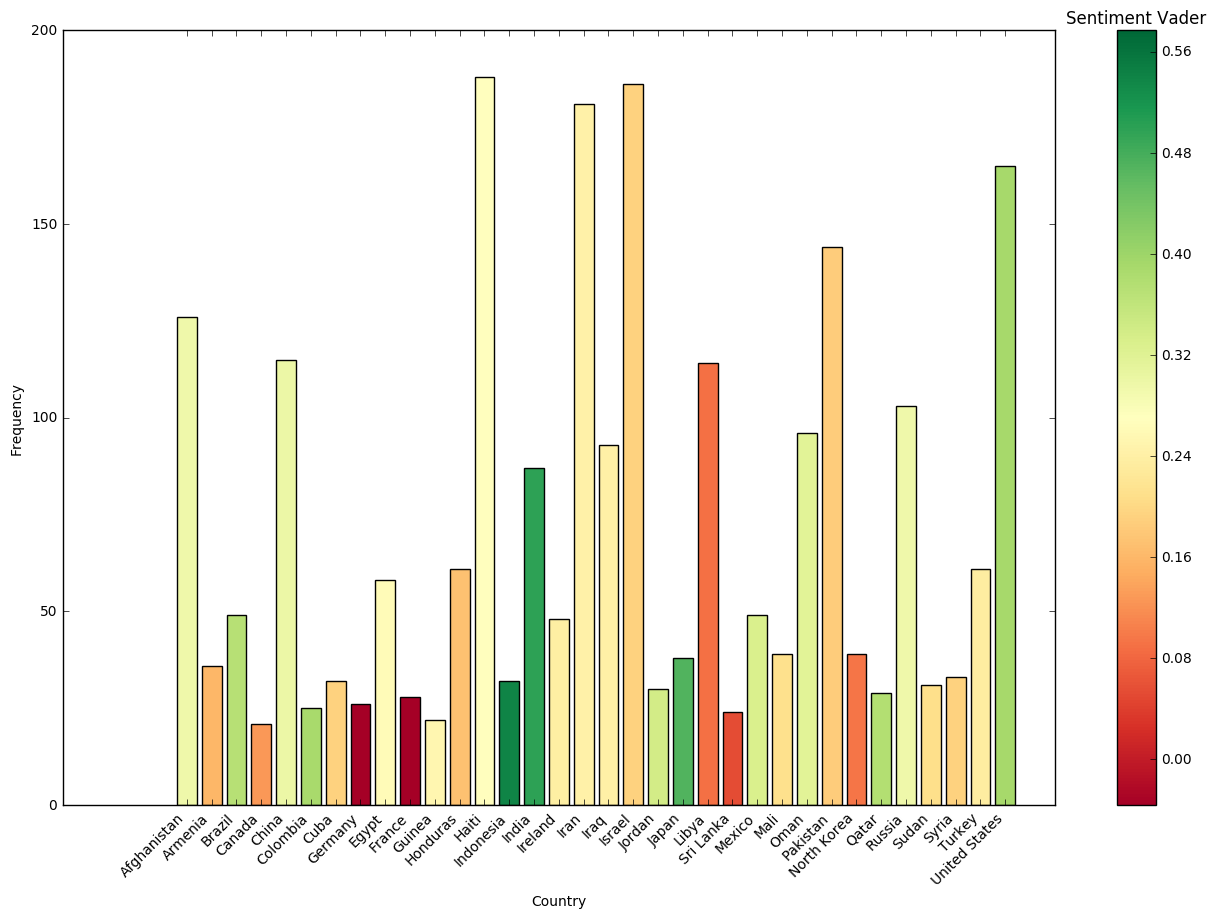

In [21]:
from matplotlib import cm
import numpy as np

plt.figure(figsize=(16, 10))
y = np.array(dataCount1['SentimentVader']/dataCount1['Frequency'])
colors = cm.RdYlGn(y / float(max(y)-min(y)))
plot = plt.scatter(y, y, c=y, cmap = 'RdYlGn')
plt.clf()
clb = plt.colorbar(plot)
clb.ax.set_title("Sentiment Vader")

plt.bar(range(dataCount1.shape[0]), dataCount1['Frequency'], align='center', tick_label=dataCount1.index, color=colors)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Country")
plt.ylabel("Frequency")
plt.show()

## LIU HU SENTIMENT

- Now, we try the LIU HU sentiment analyzer :
- We check the sentiment of every word on each email that contain at least one country and we label it as 1 : positive
- -1 : negative or 0 : neutral

In [22]:
dataCount_LiuHu = pd.DataFrame(index=Countries, columns=['Frequency', 'SentimentLiuHu'])
dataCount_LiuHu.fillna(0.0,inplace=True)
dataCount_LiuHu.head(4)

,Frequency,SentimentLiuHu
Aruba,0.0,0.0
Afghanistan,0.0,0.0
Angola,0.0,0.0
Anguilla,0.0,0.0


In [23]:
def getSentimentLiuHu(mail):
    score=0
    for token in nltk.word_tokenize(mail):
        if token in opinion_lexicon.positive():
            score+=1
        else: 
            if token in  opinion_lexicon.negative():
                score-=1
    return score/len(nltk.word_tokenize(mail))

In [24]:
def checkCountryMail_LiuHu(mail):
    for value in Country_check.values():
        for i in range(len(value)):
            if value[i] in mail:
                dataCount_LiuHu.set_value(value[0], 'Frequency',dataCount_LiuHu.get_value(value[0], 'Frequency')+1)
                dataCount_LiuHu.set_value(value[0], 'SentimentLiuHu',dataCount_LiuHu.get_value(value[0], 'SentimentLiuHu')+getSentimentLiuHu(mail))

In [ ]:
i=0
for mail in raw:
    if i%20==0:
        print(i)
    i+=1
    checkCountryMail_LiuHu(mail)

0


In [ ]:
from matplotlib import cm
import numpy as np

plt.figure(figsize=(16, 10))
y = np.array(dataCount1['SentimentVader']/dataCount1['Frequency'])
colors = cm.RdYlGn(y / float(max(y)-min(y)))
plot = plt.scatter(y, y, c=y, cmap = 'RdYlGn')
plt.clf()
clb = plt.colorbar(plot)
clb.ax.set_title("Sentiment Vader")

plt.bar(range(dataCount1.shape[0]), dataCount1['Frequency'], align='center', tick_label=dataCount1.index, color=colors)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Country")
plt.ylabel("Frequency")
plt.show()